## Train Network Basics

## How to use the dataset class

Loading a dataset requires the data to be in the correct format (see Prepare data tutorial). Just create the dataset object and use the load method:

In [1]:
import logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s %(message)s",
    datefmt="%m/%d/%Y %I:%M:%S %p",
)


from meegnet.dataloaders import EpochedDataset

sfreq = 500 # sampling frequency of 500 Hz
n_samples = 100 # only load 100 subjects for demonstration purposes
n_subjects = 100 # limit the number of samples for each subject to 100 this is automatically stratified (balanced classes)
sensortype = "Grad" # only use gradiometers

# change to your data path:
data_path = f"/home/arthur/nvme/eventclf/downsampled_{sfreq}"

# use Dataset class for data that has already been cut into trials
# else, use RestDataset with additional parameters of window and overlap to create trials.

dataset = EpochedDataset(
    sfreq=sfreq, 
    n_subjects=n_subjects,
    n_samples=n_samples,
    sensortype=sensortype,
    lso=True, # use leave subject out for data splits
)

dataset.load(data_path)

03/20/2025 10:48:42 PM Logging subjects and targets from /home/arthur/nvme/eventclf/downsampled_500...


## How to use the network class

Create the model object instance of the Model class and then use the train method with the dataset previously created.

In [2]:
from meegnet.network import Model

save_path = data_path
net_option = "meegnet"
input_size = dataset.data[0].shape
n_outputs = 2 # Here we have 2 possible outputs, binary classification task.
name = "eventclf_meegnet"

net_params = {"linear": 100, "hlayers": 3, "dropout": .5}
my_model = Model(name, net_option, input_size, n_outputs, save_path, net_params=net_params)

print(my_model.net)

my_model.train(dataset, max_epoch=15, verbose=1)

/home/arthur/.pyvenv/meegnet/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
03/20/2025 10:49:37 PM Creating DataLoaders...


MEEGNet(
  (feature_extraction): Sequential(
    (0): Conv2d(3, 100, kernel_size=(102, 1), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(100, 200, kernel_size=(1, 9), stride=(1, 1))
    (3): MaxPool2d(kernel_size=(1, 20), stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): ReLU()
    (5): Conv2d(200, 200, kernel_size=(1, 9), stride=(1, 1))
    (6): MaxPool2d(kernel_size=(1, 20), stride=1, padding=0, dilation=1, ceil_mode=False)
    (7): ReLU()
    (8): Conv2d(200, 100, kernel_size=(1, 9), stride=(1, 1))
    (9): MaxPool2d(kernel_size=(1, 20), stride=1, padding=0, dilation=1, ceil_mode=False)
    (10): ReLU()
    (11): Flatten()
    (12): Dropout(p=0.5, inplace=False)
  )
  (classif): Sequential(
    (0): Linear(in_features=31900, out_features=1000, bias=True)
    (1): Linear(in_features=1000, out_features=2, bias=True)
  )
)


03/20/2025 10:49:38 PM Starting Training with:
03/20/2025 10:49:38 PM Batch size: 128
03/20/2025 10:49:38 PM Learning rate: 1e-05
03/20/2025 10:49:38 PM Patience: 10
03/20/2025 10:49:38 PM Maximum Epoch: 15


We can print the train and validation loss of the network during training, as well as the training and validation accuracy during training.

This is helpful to check that the network learns correctly and that early stop is well implemented: stopping before overfitting.

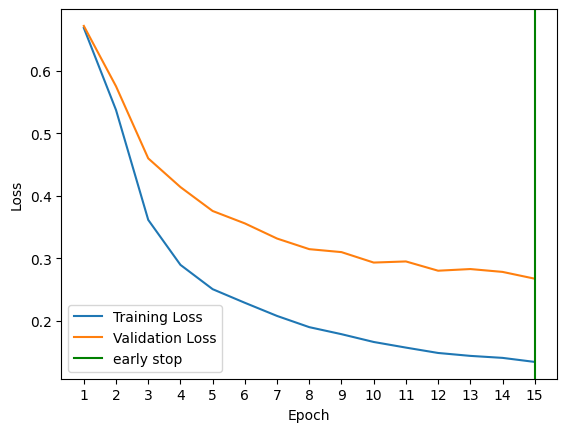

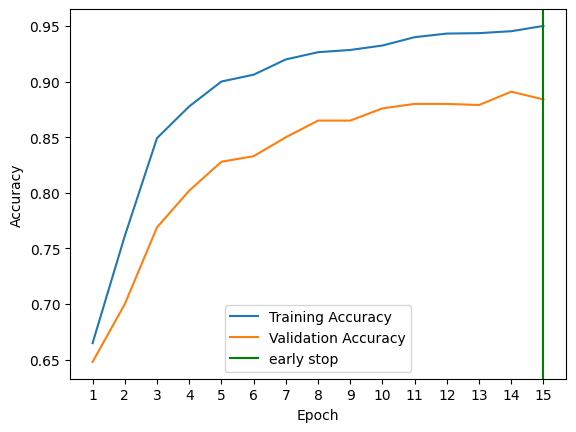

In [3]:
my_model.plot_loss()
my_model.plot_accuracy();

In our example, you can see from the figures that the max_epoch parameter we set limits our training capabilities, but we can also see that the model is learning correctly, but stopped before it could reach an optimum.

In order to correct that, we can increase the max_epoch parameter or set it to None (by default) and continue training.

In [4]:
my_model.train(dataset, continue_training=True, verbose=1)

03/20/2025 10:53:49 PM Creating DataLoaders...
03/20/2025 10:53:51 PM Starting Training with:
03/20/2025 10:53:51 PM Batch size: 128
03/20/2025 10:53:51 PM Learning rate: 1e-05
03/20/2025 10:53:51 PM Patience: 10


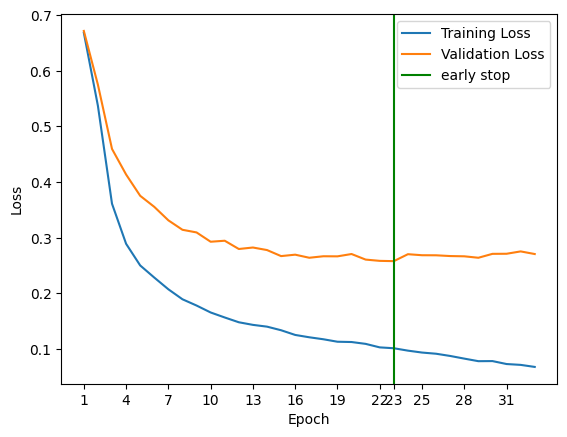

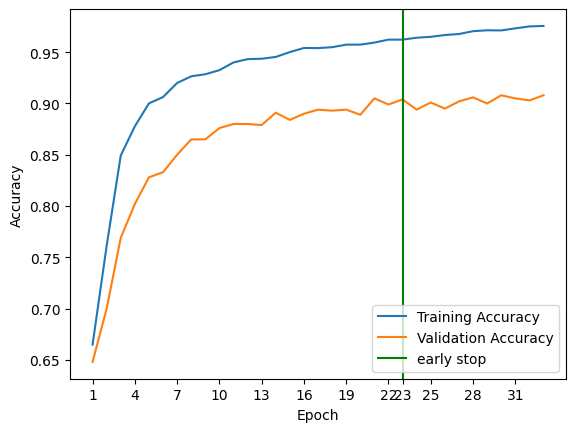

In [5]:
my_model.plot_loss()
my_model.plot_accuracy();

Now we have a better picture of the training process, and we can see that we stopped early, 10 epochs after the best epoch (23).

All training progress can be accessed through the tracker object inside the Model:

In [6]:
print("Content of tracker.progress dictionary:")
for key, value in my_model.tracker.progress.items():
    print(f"{key}, {type(value)}")

print("\nContent of tracker.best dictionary:")
for key, value in my_model.tracker.best.items():
    print(f"{key}, {value}")

Content of tracker.progress dictionary:
train_losses, <class 'list'>
train_accuracies, <class 'list'>
validation_losses, <class 'list'>
validation_accuracies, <class 'list'>

Content of tracker.best dictionary:
train_loss, 0.10161866992712021
train_accuracy, 0.9622499942779541
validation_loss, 0.2580738961696625
validation_accuracy, 0.9039999842643738
epoch, 22


Note that here best epoch is 22 because of how python indexes. The best epoch is the 23th one, which is indexed at 22.